In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, log_loss, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Add parent directory to path for imports
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import our custom modules
from utils.inference import perform_audio_inference, perform_audio_inference_fcnn
from utils.models import BirdCNN

print("All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

In [ ]:
# Config
NUM_CLASSES = 33
TEST_AUDIO_DIR = os.path.join('..', 'database', 'audio', 'test')
TEST_METADATA_PATH = os.path.join('..', 'database', 'meta', 'test_data.csv')

# Load test metadata
print("Loading test metadata...")
test_df = pd.read_csv(TEST_METADATA_PATH)


# Verify audio files exist and create file mapping
print("Verifying audio files...")
audio_files = os.listdir(TEST_AUDIO_DIR)
print(f"✓ Found {len(audio_files)} audio files in test directory")

# Create mapping of filename to full path and check if all metadata files exist
test_files = []
missing_files = []

for _, row in test_df.iterrows():
    filename = row['filename']
    audio_path = os.path.join(TEST_AUDIO_DIR, filename)
    
    if os.path.exists(audio_path):
        test_files.append({
            'filename': filename,
            'path': audio_path,
            'class_id': row['class_id']
        })
    else:
        missing_files.append(filename)

print(f"✓ Valid files: {len(test_files)}")
if missing_files:
    print(f"⚠ Missing files: {len(missing_files)}")
    print(f"  First few missing: {missing_files[:5]}")
else:
    print("✓ All metadata files found in audio directory")

In [ ]:
# Define the Configurations to try
from utils.final_models import BirdCNN_v5, BirdCNN_v5c, BirdCNN_v7, BirdCNN_v7e
from utils.fcnn_models import BirdFCNN, BirdFCNN_v1

m1_path = os.path.join('..', 'models', 'cnn1_state_dict.pth')
m2_path = os.path.join('..', 'models', 'cnn2_state_dict.pth')
m3_path = os.path.join('..', 'models', 'cnn3_state_dict.pth')
m4_path = os.path.join('..', 'models', 'cnn4_state_dict.pth')

f1_path = os.path.join('..', 'models', 'fcnn1_state_dict.pth')
f2_path = os.path.join('..', 'models', 'fcnn2_state_dict.pth')

# Final Models ({'name': (Model Class, PTH Path)})
final_cnn_models = {
    'm0': (BirdCNN_v5, m1_path),
    'm1': (BirdCNN_v5c, m2_path),
    'm2': (BirdCNN_v7, m3_path),
    'm3': (BirdCNN_v7e, m4_path),
}

final_fcnn_models = {
    'f0': (BirdFCNN, f1_path),
    'f1': (BirdFCNN_v1, f2_path),
}

# Storage for results
all_predictions = []
all_probabilities = []
all_true_labels = []
failed_files = []

In [ ]:
# Clear any previous results and verify model files
print("Verifying model files...")

# Check CNN models
print("\nCNN Models:")
for name, (model_class, model_path) in final_cnn_models.items():
    exists = os.path.exists(model_path)
    status = "✓" if exists else "❌"
    print(f"  {status} {name}: {model_class.__name__} -> {model_path}")
    if not exists:
        print(f"    WARNING: Model file not found!")

# Check FCNN models
print("\nFCNN Models:")
for name, (model_class, model_path) in final_fcnn_models.items():
    exists = os.path.exists(model_path)
    status = "✓" if exists else "❌"
    print(f"  {status} {name}: {model_class.__name__} -> {model_path}")
    if not exists:
        print(f"    WARNING: Model file not found!")

print(f"\nTotal models to test: {len(final_cnn_models) + len(final_fcnn_models)}")
print("Ready to start testing...")

In [17]:
# Test all CNN models
cnn_results = {}

for model_name, (model_class, model_path) in final_cnn_models.items():
    print(f"\n{'='*50}")
    print(f"Testing CNN model: {model_name}")
    print(f"Model class: {model_class.__name__}")
    print(f"Model path: {model_path}")
    print(f"{'='*50}")
    
    # Storage for this model's results
    all_predictions = []
    all_probabilities = []
    all_true_labels = []
    failed_files = []
    
    # Process each test file
    for i, file_info in enumerate(tqdm(test_files, desc=f"Processing {model_name}")):
        try:
            # Perform inference
            probabilities = perform_audio_inference(
                audio_path=file_info['path'],
                model_class=model_class,
                model_path=model_path,
                reduce_noise=False
            )
            
            # Get predicted class (argmax of probabilities)
            predicted_class = np.argmax(probabilities)
            
            # Store results
            all_probabilities.append(probabilities)
            all_predictions.append(predicted_class)
            all_true_labels.append(file_info['class_id'])
            
            # Progress update every 10 files (reduced for better feedback)
            if (i + 1) % 10 == 0:
                print(f"Processed {i + 1}/{len(test_files)} files")
                
        except Exception as e:
            print(f"Failed to process {file_info['filename']}: {str(e)}")
            failed_files.append(file_info['filename'])
            continue
    
    # Calculate metrics for this model
    if len(all_predictions) > 0:
        accuracy = accuracy_score(all_true_labels, all_predictions)
        f1 = f1_score(all_true_labels, all_predictions, average='weighted')
        
        # Store results
        cnn_results[model_name] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'predictions': all_predictions,
            'probabilities': all_probabilities,
            'true_labels': all_true_labels,
            'failed_files': failed_files,
            'model_class': model_class.__name__
        }
        
        print(f"\n✓ {model_name} results:")
        print(f"  Successfully processed: {len(all_predictions)} files")
        print(f"  Failed files: {len(failed_files)}")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        
        if failed_files:
            print(f"  Failed files: {failed_files[:3]}{'...' if len(failed_files) > 3 else ''}")
    else:
        print(f"❌ No successful predictions for {model_name}")

print(f"\n{'='*60}")
print("CNN MODELS TESTING COMPLETED")
print(f"{'='*60}")

Processing m0:  39%|███▉      | 100/254 [00:13<00:22,  6.88it/s]

Processed 100/254 files


Processing m0:  44%|████▎     | 111/254 [00:15<00:18,  7.66it/s]

Processed 110/254 files


Processing m0:  48%|████▊     | 121/254 [00:16<00:16,  8.30it/s]

Processed 120/254 files


Processing m0:  52%|█████▏    | 131/254 [00:17<00:14,  8.63it/s]

Processed 130/254 files


Processing m0:  56%|█████▌    | 141/254 [00:18<00:14,  7.82it/s]

Processed 140/254 files


Processing m0:  59%|█████▉    | 151/254 [00:20<00:13,  7.81it/s]

Processed 150/254 files


Processing m0:  63%|██████▎   | 161/254 [00:21<00:12,  7.27it/s]

Processed 160/254 files


Processing m0:  67%|██████▋   | 170/254 [00:22<00:11,  7.59it/s]

Processed 170/254 files


Processing m0:  71%|███████   | 180/254 [00:24<00:10,  6.81it/s]

Processed 180/254 files


Processing m0:  75%|███████▌  | 191/254 [00:25<00:07,  8.13it/s]

Processed 190/254 files


Processing m0:  80%|███████▉  | 202/254 [00:26<00:04, 11.01it/s]

Processed 200/254 files


Processing m0:  83%|████████▎ | 212/254 [00:28<00:06,  6.34it/s]

Processed 210/254 files


Processing m0:  87%|████████▋ | 222/254 [00:29<00:03, 10.19it/s]

Processed 220/254 files
Failed to process XC599219.ogg: No usable segments extracted from audio file: ..\database\audio\test\XC599219.ogg


Processing m0:  91%|█████████ | 231/254 [00:31<00:02,  7.77it/s]

Processed 230/254 files


Processing m0:  95%|█████████▍| 241/254 [00:32<00:01,  6.74it/s]

Processed 240/254 files


Processing m0:  99%|█████████▉| 251/254 [00:34<00:00,  8.03it/s]

Processed 250/254 files


Processing m0: 100%|██████████| 254/254 [00:34<00:00,  7.39it/s]



✓ m0 results:
  Successfully processed: 251 files
  Failed files: 3
  Accuracy: 0.0239
  F1 Score: 0.0041
  Failed files: ['XC599531.ogg', 'XC147035.ogg', 'XC599219.ogg']

Testing CNN model: m1
Model class: BirdCNN_v5c
Model path: ..\models\cnn2_state_dict.pth


Processing m1:   4%|▍         | 11/254 [00:01<00:30,  8.09it/s]

Processed 10/254 files


Processing m1:   8%|▊         | 21/254 [00:02<00:31,  7.47it/s]

Processed 20/254 files


Processing m1:  12%|█▏        | 31/254 [00:04<00:31,  7.14it/s]

Processed 30/254 files


Processing m1:  16%|█▌        | 40/254 [00:05<00:30,  7.00it/s]

Processed 40/254 files


Processing m1:  20%|██        | 51/254 [00:07<00:30,  6.66it/s]

Processed 50/254 files


Processing m1:  24%|██▍       | 61/254 [00:08<00:26,  7.33it/s]

Processed 60/254 files


Processing m1:  28%|██▊       | 70/254 [00:09<00:27,  6.79it/s]

Processed 70/254 files


Processing m1:  32%|███▏      | 81/254 [00:11<00:25,  6.91it/s]

Processed 80/254 files


Processing m1:  33%|███▎      | 85/254 [00:12<00:22,  7.52it/s]

Failed to process XC599531.ogg: No usable segments extracted from audio file: ..\database\audio\test\XC599531.ogg


Processing m1:  35%|███▌      | 90/254 [00:12<00:17,  9.44it/s]

Failed to process XC147035.ogg: No usable segments extracted from audio file: ..\database\audio\test\XC147035.ogg
Processed 90/254 files


Processing m1:  39%|███▉      | 100/254 [00:14<00:24,  6.25it/s]

Processed 100/254 files


Processing m1:  44%|████▎     | 111/254 [00:15<00:19,  7.16it/s]

Processed 110/254 files


Processing m1:  48%|████▊     | 121/254 [00:17<00:16,  7.98it/s]

Processed 120/254 files


Processing m1:  52%|█████▏    | 131/254 [00:18<00:15,  8.01it/s]

Processed 130/254 files


Processing m1:  56%|█████▌    | 141/254 [00:20<00:15,  7.10it/s]

Processed 140/254 files


Processing m1:  59%|█████▉    | 151/254 [00:21<00:13,  7.39it/s]

Processed 150/254 files


Processing m1:  63%|██████▎   | 161/254 [00:23<00:13,  6.97it/s]

Processed 160/254 files


Processing m1:  67%|██████▋   | 171/254 [00:24<00:11,  7.09it/s]

Processed 170/254 files


Processing m1:  71%|███████▏  | 181/254 [00:25<00:10,  6.76it/s]

Processed 180/254 files


Processing m1:  75%|███████▌  | 191/254 [00:27<00:08,  7.08it/s]

Processed 190/254 files


Processing m1:  79%|███████▉  | 201/254 [00:28<00:06,  7.91it/s]

Processed 200/254 files


Processing m1:  83%|████████▎ | 211/254 [00:30<00:08,  4.84it/s]

Processed 210/254 files


Processing m1:  87%|████████▋ | 222/254 [00:32<00:03,  8.66it/s]

Processed 220/254 files
Failed to process XC599219.ogg: No usable segments extracted from audio file: ..\database\audio\test\XC599219.ogg


Processing m1:  91%|█████████ | 231/254 [00:33<00:03,  6.72it/s]

Processed 230/254 files


Processing m1:  95%|█████████▍| 241/254 [00:35<00:02,  6.13it/s]

Processed 240/254 files


Processing m1:  99%|█████████▉| 251/254 [00:37<00:00,  7.19it/s]

Processed 250/254 files


Processing m1: 100%|██████████| 254/254 [00:37<00:00,  6.78it/s]



✓ m1 results:
  Successfully processed: 251 files
  Failed files: 3
  Accuracy: 0.0319
  F1 Score: 0.0044
  Failed files: ['XC599531.ogg', 'XC147035.ogg', 'XC599219.ogg']

Testing CNN model: m2
Model class: BirdCNN_v7
Model path: ..\models\cnn3_state_dict.pth


Processing m2:   4%|▍         | 11/254 [00:02<00:55,  4.41it/s]

Processed 10/254 files


Processing m2:   8%|▊         | 20/254 [00:04<00:55,  4.22it/s]

Processed 20/254 files


Processing m2:  12%|█▏        | 31/254 [00:07<00:49,  4.47it/s]

Processed 30/254 files


Processing m2:  16%|█▌        | 40/254 [00:09<01:00,  3.56it/s]

Processed 40/254 files


Processing m2:  20%|█▉        | 50/254 [00:12<00:57,  3.57it/s]

Processed 50/254 files


Processing m2:  24%|██▎       | 60/254 [00:15<00:41,  4.64it/s]

Processed 60/254 files


Processing m2:  28%|██▊       | 70/254 [00:17<00:45,  4.06it/s]

Processed 70/254 files


Processing m2:  31%|███▏      | 80/254 [00:20<00:44,  3.93it/s]

Processed 80/254 files


Processing m2:  33%|███▎      | 85/254 [00:22<00:43,  3.90it/s]

Failed to process XC599531.ogg: No usable segments extracted from audio file: ..\database\audio\test\XC599531.ogg


Processing m2:  35%|███▌      | 90/254 [00:23<00:30,  5.40it/s]

Failed to process XC147035.ogg: No usable segments extracted from audio file: ..\database\audio\test\XC147035.ogg
Processed 90/254 files


Processing m2:  39%|███▉      | 100/254 [00:25<00:43,  3.55it/s]

Processed 100/254 files


Processing m2:  43%|████▎     | 110/254 [00:28<00:35,  4.02it/s]

Processed 110/254 files


Processing m2:  47%|████▋     | 120/254 [00:31<00:28,  4.66it/s]

Processed 120/254 files


Processing m2:  52%|█████▏    | 131/254 [00:33<00:27,  4.51it/s]

Processed 130/254 files


Processing m2:  55%|█████▌    | 140/254 [00:36<00:25,  4.47it/s]

Processed 140/254 files


Processing m2:  59%|█████▉    | 150/254 [00:38<00:21,  4.78it/s]

Processed 150/254 files


Processing m2:  63%|██████▎   | 160/254 [00:41<00:25,  3.69it/s]

Processed 160/254 files


Processing m2:  67%|██████▋   | 170/254 [00:43<00:21,  3.86it/s]

Processed 170/254 files


Processing m2:  71%|███████▏  | 181/254 [00:46<00:17,  4.07it/s]

Processed 180/254 files


Processing m2:  75%|███████▍  | 190/254 [00:49<00:16,  3.88it/s]

Processed 190/254 files


Processing m2:  79%|███████▉  | 201/254 [00:51<00:10,  5.02it/s]

Processed 200/254 files


Processing m2:  83%|████████▎ | 210/254 [00:54<00:17,  2.50it/s]

Processed 210/254 files


Processing m2:  87%|████████▋ | 220/254 [00:56<00:08,  4.12it/s]

Processed 220/254 files
Failed to process XC599219.ogg: No usable segments extracted from audio file: ..\database\audio\test\XC599219.ogg


Processing m2:  91%|█████████ | 230/254 [00:59<00:05,  4.12it/s]

Processed 230/254 files


Processing m2:  94%|█████████▍| 240/254 [01:02<00:04,  3.50it/s]

Processed 240/254 files


Processing m2:  98%|█████████▊| 250/254 [01:05<00:00,  4.30it/s]

Processed 250/254 files


Processing m2: 100%|██████████| 254/254 [01:05<00:00,  3.85it/s]



✓ m2 results:
  Successfully processed: 251 files
  Failed files: 3
  Accuracy: 0.0518
  F1 Score: 0.0081
  Failed files: ['XC599531.ogg', 'XC147035.ogg', 'XC599219.ogg']

Testing CNN model: m3
Model class: BirdCNN_v7e
Model path: ..\models\cnn4_state_dict.pth


Processing m3:   4%|▍         | 10/254 [00:03<01:17,  3.15it/s]

Processed 10/254 files


Processing m3:   8%|▊         | 20/254 [00:05<01:05,  3.59it/s]

Processed 20/254 files


Processing m3:  12%|█▏        | 30/254 [00:08<00:58,  3.80it/s]

Processed 30/254 files


Processing m3:  16%|█▌        | 40/254 [00:11<01:04,  3.32it/s]

Processed 40/254 files


Processing m3:  20%|█▉        | 50/254 [00:14<01:02,  3.24it/s]

Processed 50/254 files


Processing m3:  24%|██▎       | 60/254 [00:17<00:48,  4.03it/s]

Processed 60/254 files


Processing m3:  28%|██▊       | 70/254 [00:20<00:48,  3.77it/s]

Processed 70/254 files


Processing m3:  31%|███▏      | 80/254 [00:23<00:46,  3.78it/s]

Processed 80/254 files


Processing m3:  33%|███▎      | 85/254 [00:24<00:51,  3.31it/s]

Failed to process XC599531.ogg: No usable segments extracted from audio file: ..\database\audio\test\XC599531.ogg


Processing m3:  35%|███▍      | 88/254 [00:25<00:46,  3.61it/s]

Failed to process XC147035.ogg: No usable segments extracted from audio file: ..\database\audio\test\XC147035.ogg


Processing m3:  35%|███▌      | 90/254 [00:25<00:34,  4.72it/s]

Processed 90/254 files


Processing m3:  39%|███▉      | 100/254 [00:28<00:45,  3.38it/s]

Processed 100/254 files


Processing m3:  43%|████▎     | 110/254 [00:31<00:43,  3.32it/s]

Processed 110/254 files


Processing m3:  47%|████▋     | 120/254 [00:34<00:35,  3.78it/s]

Processed 120/254 files


Processing m3:  51%|█████     | 130/254 [00:37<00:36,  3.40it/s]

Processed 130/254 files


Processing m3:  55%|█████▌    | 140/254 [00:41<00:31,  3.59it/s]

Processed 140/254 files


Processing m3:  59%|█████▉    | 150/254 [00:43<00:27,  3.83it/s]

Processed 150/254 files


Processing m3:  63%|██████▎   | 160/254 [00:47<00:29,  3.16it/s]

Processed 160/254 files


Processing m3:  67%|██████▋   | 170/254 [00:49<00:24,  3.41it/s]

Processed 170/254 files


Processing m3:  71%|███████   | 180/254 [00:52<00:23,  3.17it/s]

Processed 180/254 files


Processing m3:  75%|███████▍  | 190/254 [00:55<00:18,  3.55it/s]

Processed 190/254 files


Processing m3:  79%|███████▊  | 200/254 [00:58<00:13,  4.12it/s]

Processed 200/254 files


Processing m3:  83%|████████▎ | 210/254 [01:02<00:19,  2.21it/s]

Processed 210/254 files


Processing m3:  87%|████████▋ | 220/254 [01:05<00:09,  3.49it/s]

Processed 220/254 files
Failed to process XC599219.ogg: No usable segments extracted from audio file: ..\database\audio\test\XC599219.ogg


Processing m3:  91%|█████████ | 230/254 [01:08<00:06,  3.65it/s]

Processed 230/254 files


Processing m3:  94%|█████████▍| 240/254 [01:11<00:04,  2.93it/s]

Processed 240/254 files


Processing m3:  98%|█████████▊| 250/254 [01:14<00:01,  3.55it/s]

Processed 250/254 files


Processing m3: 100%|██████████| 254/254 [01:15<00:00,  3.35it/s]


✓ m3 results:
  Successfully processed: 251 files
  Failed files: 3
  Accuracy: 0.0677
  F1 Score: 0.0296
  Failed files: ['XC599531.ogg', 'XC147035.ogg', 'XC599219.ogg']

CNN MODELS TESTING COMPLETED


In [18]:
# Test all FCNN models
fcnn_results = {}

for model_name, (model_class, model_path) in final_fcnn_models.items():
    print(f"\n{'='*50}")
    print(f"Testing FCNN model: {model_name}")
    print(f"Model class: {model_class.__name__}")
    print(f"Model path: {model_path}")
    print(f"{'='*50}")
    
    # Storage for this model's results
    all_predictions = []
    all_probabilities = []
    all_true_labels = []
    failed_files = []
    
    # Process each test file
    for i, file_info in enumerate(tqdm(test_files, desc=f"Processing {model_name}")):
        try:
            # Perform inference
            probabilities = perform_audio_inference_fcnn(
                audio_path=file_info['path'],
                model_class=model_class,
                model_path=model_path,
                reduce_noise=False
            )
            
            # Get predicted class (argmax of probabilities)
            predicted_class = np.argmax(probabilities)
            
            # Store results
            all_probabilities.append(probabilities)
            all_predictions.append(predicted_class)
            all_true_labels.append(file_info['class_id'])
            
            # Progress update every 10 files (reduced for better feedback)
            if (i + 1) % 10 == 0:
                print(f"Processed {i + 1}/{len(test_files)} files")
                
        except Exception as e:
            print(f"Failed to process {file_info['filename']}: {str(e)}")
            failed_files.append(file_info['filename'])
            continue
    
    # Calculate metrics for this model
    if len(all_predictions) > 0:
        accuracy = accuracy_score(all_true_labels, all_predictions)
        f1 = f1_score(all_true_labels, all_predictions, average='weighted')
        
        # Store results
        fcnn_results[model_name] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'predictions': all_predictions,
            'probabilities': all_probabilities,
            'true_labels': all_true_labels,
            'failed_files': failed_files,
            'model_class': model_class.__name__
        }
        
        print(f"\n✓ {model_name} results:")
        print(f"  Successfully processed: {len(all_predictions)} files")
        print(f"  Failed files: {len(failed_files)}")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        
        if failed_files:
            print(f"  Failed files: {failed_files[:3]}{'...' if len(failed_files) > 3 else ''}")
    else:
        print(f"❌ No successful predictions for {model_name}")

print(f"\n{'='*60}")
print("FCNN MODELS TESTING COMPLETED")
print(f"{'='*60}")


Testing FCNN model: f0
Model class: BirdFCNN
Model path: ..\models\fcnn1_state_dict.pth


Processing f0:   4%|▍         | 11/254 [00:02<00:48,  5.00it/s]

Processed 10/254 files


Processing f0:   8%|▊         | 21/254 [00:04<00:46,  4.99it/s]

Processed 20/254 files


Processing f0:  12%|█▏        | 31/254 [00:06<00:44,  5.04it/s]

Processed 30/254 files


Processing f0:  16%|█▌        | 40/254 [00:08<00:46,  4.59it/s]

Processed 40/254 files


Processing f0:  20%|█▉        | 50/254 [00:10<00:42,  4.81it/s]

Processed 50/254 files


Processing f0:  24%|██▎       | 60/254 [00:12<00:37,  5.19it/s]

Processed 60/254 files


Processing f0:  28%|██▊       | 70/254 [00:14<00:37,  4.97it/s]

Processed 70/254 files


Processing f0:  31%|███▏      | 80/254 [00:16<00:32,  5.37it/s]

Processed 80/254 files


Processing f0:  33%|███▎      | 85/254 [00:17<00:33,  5.09it/s]

Failed to process XC599531.ogg: No usable segments extracted from audio file: ..\database\audio\test\XC599531.ogg


Processing f0:  35%|███▌      | 90/254 [00:18<00:24,  6.78it/s]

Failed to process XC147035.ogg: No usable segments extracted from audio file: ..\database\audio\test\XC147035.ogg
Processed 90/254 files


Processing f0:  39%|███▉      | 100/254 [00:20<00:31,  4.91it/s]

Processed 100/254 files


Processing f0:  43%|████▎     | 110/254 [00:22<00:28,  5.00it/s]

Processed 110/254 files


Processing f0:  48%|████▊     | 121/254 [00:24<00:25,  5.19it/s]

Processed 120/254 files


Processing f0:  52%|█████▏    | 131/254 [00:26<00:22,  5.37it/s]

Processed 130/254 files


Processing f0:  55%|█████▌    | 140/254 [00:28<00:23,  4.94it/s]

Processed 140/254 files


Processing f0:  59%|█████▉    | 150/254 [00:30<00:20,  5.05it/s]

Processed 150/254 files


Processing f0:  63%|██████▎   | 160/254 [00:32<00:21,  4.29it/s]

Processed 160/254 files


Processing f0:  67%|██████▋   | 170/254 [00:35<00:19,  4.37it/s]

Processed 170/254 files


Processing f0:  71%|███████▏  | 181/254 [00:37<00:15,  4.84it/s]

Processed 180/254 files


Processing f0:  75%|███████▍  | 190/254 [00:39<00:12,  5.00it/s]

Processed 190/254 files


Processing f0:  79%|███████▉  | 201/254 [00:41<00:09,  5.54it/s]

Processed 200/254 files


Processing f0:  83%|████████▎ | 211/254 [00:43<00:10,  3.94it/s]

Processed 210/254 files


Processing f0:  87%|████████▋ | 220/254 [00:45<00:06,  4.96it/s]

Processed 220/254 files
Failed to process XC599219.ogg: No usable segments extracted from audio file: ..\database\audio\test\XC599219.ogg


Processing f0:  91%|█████████ | 230/254 [00:47<00:04,  5.04it/s]

Processed 230/254 files


Processing f0:  94%|█████████▍| 240/254 [00:50<00:03,  4.50it/s]

Processed 240/254 files


Processing f0:  98%|█████████▊| 250/254 [00:52<00:00,  4.98it/s]

Processed 250/254 files


Processing f0: 100%|██████████| 254/254 [00:53<00:00,  4.78it/s]



✓ f0 results:
  Successfully processed: 251 files
  Failed files: 3
  Accuracy: 0.0438
  F1 Score: 0.0232
  Failed files: ['XC599531.ogg', 'XC147035.ogg', 'XC599219.ogg']

Testing FCNN model: f1
Model class: BirdFCNN_v1
Model path: ..\models\fcnn2_state_dict.pth


Processing f1:   4%|▍         | 10/254 [00:03<01:28,  2.75it/s]

Processed 10/254 files


Processing f1:   8%|▊         | 20/254 [00:07<01:24,  2.76it/s]

Processed 20/254 files


Processing f1:  12%|█▏        | 30/254 [00:11<01:23,  2.67it/s]

Processed 30/254 files


Processing f1:  16%|█▌        | 40/254 [00:14<01:22,  2.59it/s]

Processed 40/254 files


Processing f1:  20%|█▉        | 50/254 [00:19<01:36,  2.12it/s]

Processed 50/254 files


Processing f1:  24%|██▎       | 60/254 [00:24<01:21,  2.39it/s]

Processed 60/254 files


Processing f1:  28%|██▊       | 70/254 [00:28<01:22,  2.23it/s]

Processed 70/254 files


Processing f1:  31%|███▏      | 80/254 [00:33<01:13,  2.36it/s]

Processed 80/254 files


Processing f1:  33%|███▎      | 85/254 [00:35<01:12,  2.35it/s]

Failed to process XC599531.ogg: No usable segments extracted from audio file: ..\database\audio\test\XC599531.ogg


Processing f1:  35%|███▍      | 88/254 [00:36<01:05,  2.55it/s]

Failed to process XC147035.ogg: No usable segments extracted from audio file: ..\database\audio\test\XC147035.ogg


Processing f1:  35%|███▌      | 90/254 [00:36<00:50,  3.22it/s]

Processed 90/254 files


Processing f1:  39%|███▉      | 100/254 [00:41<01:11,  2.17it/s]

Processed 100/254 files


Processing f1:  43%|████▎     | 110/254 [00:45<01:01,  2.32it/s]

Processed 110/254 files


Processing f1:  47%|████▋     | 120/254 [00:50<00:55,  2.40it/s]

Processed 120/254 files


Processing f1:  51%|█████     | 130/254 [00:54<00:54,  2.27it/s]

Processed 130/254 files


Processing f1:  55%|█████▌    | 140/254 [00:58<00:42,  2.68it/s]

Processed 140/254 files


Processing f1:  59%|█████▉    | 150/254 [01:02<00:37,  2.78it/s]

Processed 150/254 files


Processing f1:  63%|██████▎   | 160/254 [01:06<00:36,  2.54it/s]

Processed 160/254 files


Processing f1:  67%|██████▋   | 170/254 [01:10<00:30,  2.79it/s]

Processed 170/254 files


Processing f1:  71%|███████   | 180/254 [01:13<00:28,  2.55it/s]

Processed 180/254 files


Processing f1:  75%|███████▍  | 190/254 [01:17<00:23,  2.75it/s]

Processed 190/254 files


Processing f1:  79%|███████▊  | 200/254 [01:21<00:18,  2.88it/s]

Processed 200/254 files


Processing f1:  83%|████████▎ | 210/254 [01:25<00:21,  2.09it/s]

Processed 210/254 files


Processing f1:  87%|████████▋ | 220/254 [01:29<00:12,  2.71it/s]

Processed 220/254 files
Failed to process XC599219.ogg: No usable segments extracted from audio file: ..\database\audio\test\XC599219.ogg


Processing f1:  91%|█████████ | 230/254 [01:32<00:08,  2.76it/s]

Processed 230/254 files


Processing f1:  94%|█████████▍| 240/254 [01:37<00:06,  2.12it/s]

Processed 240/254 files


Processing f1:  98%|█████████▊| 250/254 [01:41<00:01,  2.39it/s]

Processed 250/254 files


Processing f1: 100%|██████████| 254/254 [01:43<00:00,  2.45it/s]


✓ f1 results:
  Successfully processed: 251 files
  Failed files: 3
  Accuracy: 0.0956
  F1 Score: 0.0469
  Failed files: ['XC599531.ogg', 'XC147035.ogg', 'XC599219.ogg']

FCNN MODELS TESTING COMPLETED


## Results

FINAL MODEL COMPARISON RESULTS
  Model Model_Type  Model_Class  F1_Score  Accuracy
0    m0        CNN   BirdCNN_v5    0.0041    0.0239
1    m1        CNN  BirdCNN_v5c    0.0044    0.0319
2    m2        CNN   BirdCNN_v7    0.0081    0.0518
3    m3        CNN  BirdCNN_v7e    0.0296    0.0677
4    f0       FCNN     BirdFCNN    0.0232    0.0438
5    f1       FCNN  BirdFCNN_v1    0.0469    0.0956

🏆 BEST MODEL: f1
   Model Type: FCNN
   Model Class: BirdFCNN_v1
   F1 Score: 0.0469
   Accuracy: 0.0956


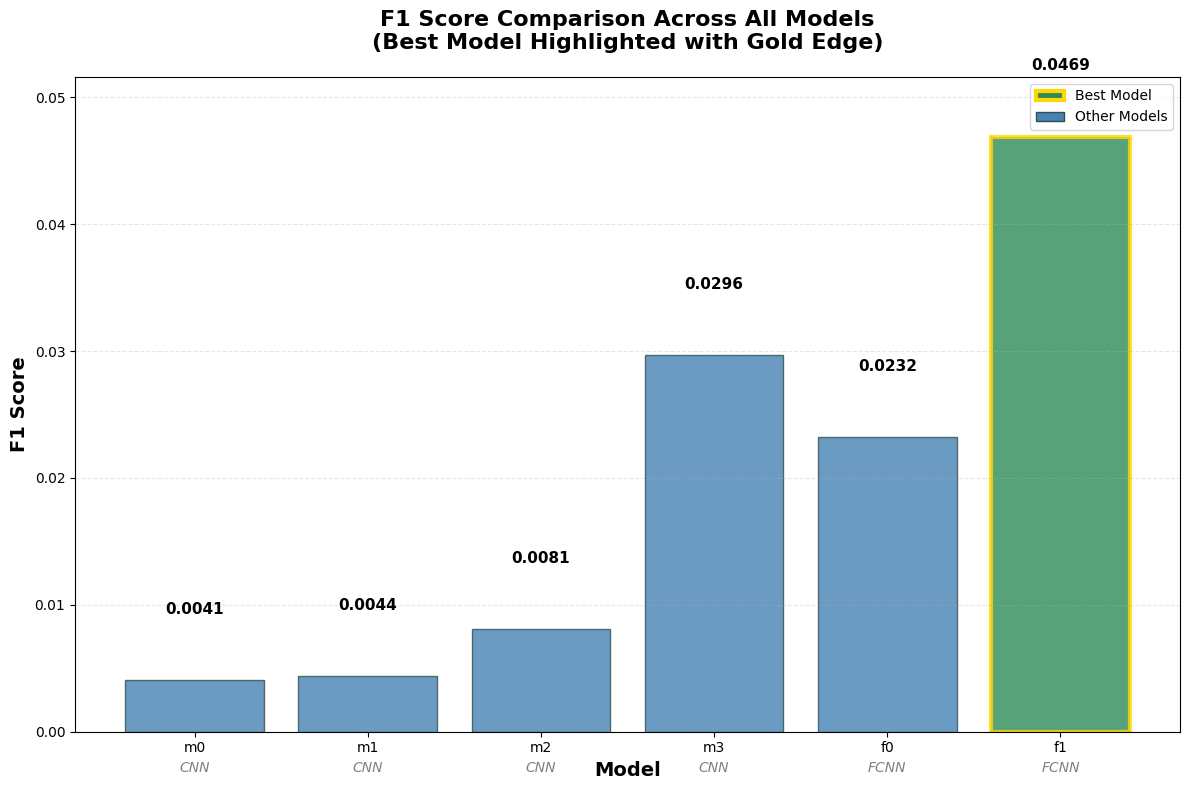


DETAILED ANALYSIS

F1 Score Statistics:
  Best F1 Score: 0.0469 (f1)
  Worst F1 Score: 0.0041 (m0)
  Average F1 Score: 0.0194
  Standard Deviation: 0.0156

Model Type Performance:
  CNN Models - Average F1: 0.0115, Best: 0.0296
  FCNN Models - Average F1: 0.0350, Best: 0.0469

💾 Results saved to: ../models/test_results_comparison.csv


In [19]:
# Combine all results and create visualization
all_results = {**cnn_results, **fcnn_results}

# Extract F1 scores and model info for plotting
model_names = []
f1_scores = []
model_types = []
model_classes = []

for model_name, results in all_results.items():
    model_names.append(model_name)
    f1_scores.append(results['f1_score'])
    model_types.append('CNN' if model_name.startswith('m') else 'FCNN')
    model_classes.append(results['model_class'])

# Create a summary DataFrame
results_df = pd.DataFrame({
    'Model': model_names,
    'Model_Type': model_types,
    'Model_Class': model_classes,
    'F1_Score': f1_scores,
    'Accuracy': [all_results[name]['accuracy'] for name in model_names]
})

# Display results table
print("="*80)
print("FINAL MODEL COMPARISON RESULTS")
print("="*80)
print(results_df.round(4))
print("="*80)

# Find the best model
best_model_idx = np.argmax(f1_scores)
best_model = model_names[best_model_idx]
best_f1 = f1_scores[best_model_idx]

print(f"\n🏆 BEST MODEL: {best_model}")
print(f"   Model Type: {model_types[best_model_idx]}")
print(f"   Model Class: {model_classes[best_model_idx]}")
print(f"   F1 Score: {best_f1:.4f}")
print(f"   Accuracy: {all_results[best_model]['accuracy']:.4f}")

# Create the main F1 Score comparison chart
plt.figure(figsize=(12, 8))

# Create colors - highlight the best model
colors = ['#2E8B57' if i == best_model_idx else '#4682B4' for i in range(len(model_names))]
edge_colors = ['#FFD700' if i == best_model_idx else '#2F4F4F' for i in range(len(model_names))]
edge_widths = [3 if i == best_model_idx else 1 for i in range(len(model_names))]

# Create the bar chart
bars = plt.bar(model_names, f1_scores, color=colors, edgecolor=edge_colors, linewidth=edge_widths, alpha=0.8)

# Customize the chart
plt.title('F1 Score Comparison Across All Models\n(Best Model Highlighted with Gold Edge)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Model', fontsize=14, fontweight='bold')
plt.ylabel('F1 Score', fontsize=14, fontweight='bold')
plt.ylim(0, max(f1_scores) * 1.1)

# Add value labels on top of bars
for i, (bar, f1_score) in enumerate(zip(bars, f1_scores)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{f1_score:.4f}',
             ha='center', va='bottom', fontweight='bold',
             fontsize=11, color='black')

# Add model type annotations below x-axis
for i, (name, model_type) in enumerate(zip(model_names, model_types)):
    plt.text(i, -max(f1_scores) * 0.05, model_type, 
             ha='center', va='top', fontsize=10, 
             style='italic', color='gray')

# Add grid for better readability
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2E8B57', edgecolor='#FFD700', linewidth=3, label='Best Model'),
    Patch(facecolor='#4682B4', edgecolor='#2F4F4F', linewidth=1, label='Other Models')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

# Additional detailed analysis
print(f"\n{'='*80}")
print("DETAILED ANALYSIS")
print(f"{'='*80}")

print(f"\nF1 Score Statistics:")
print(f"  Best F1 Score: {max(f1_scores):.4f} ({best_model})")
print(f"  Worst F1 Score: {min(f1_scores):.4f} ({model_names[np.argmin(f1_scores)]})")
print(f"  Average F1 Score: {np.mean(f1_scores):.4f}")
print(f"  Standard Deviation: {np.std(f1_scores):.4f}")

print(f"\nModel Type Performance:")
cnn_f1_scores = [f1_scores[i] for i, t in enumerate(model_types) if t == 'CNN']
fcnn_f1_scores = [f1_scores[i] for i, t in enumerate(model_types) if t == 'FCNN']

if cnn_f1_scores:
    print(f"  CNN Models - Average F1: {np.mean(cnn_f1_scores):.4f}, Best: {max(cnn_f1_scores):.4f}")
if fcnn_f1_scores:
    print(f"  FCNN Models - Average F1: {np.mean(fcnn_f1_scores):.4f}, Best: {max(fcnn_f1_scores):.4f}")

# Save results to CSV for future reference
results_df.to_csv('../models/test_results_comparison.csv', index=False)
print(f"\n💾 Results saved to: ../models/test_results_comparison.csv")

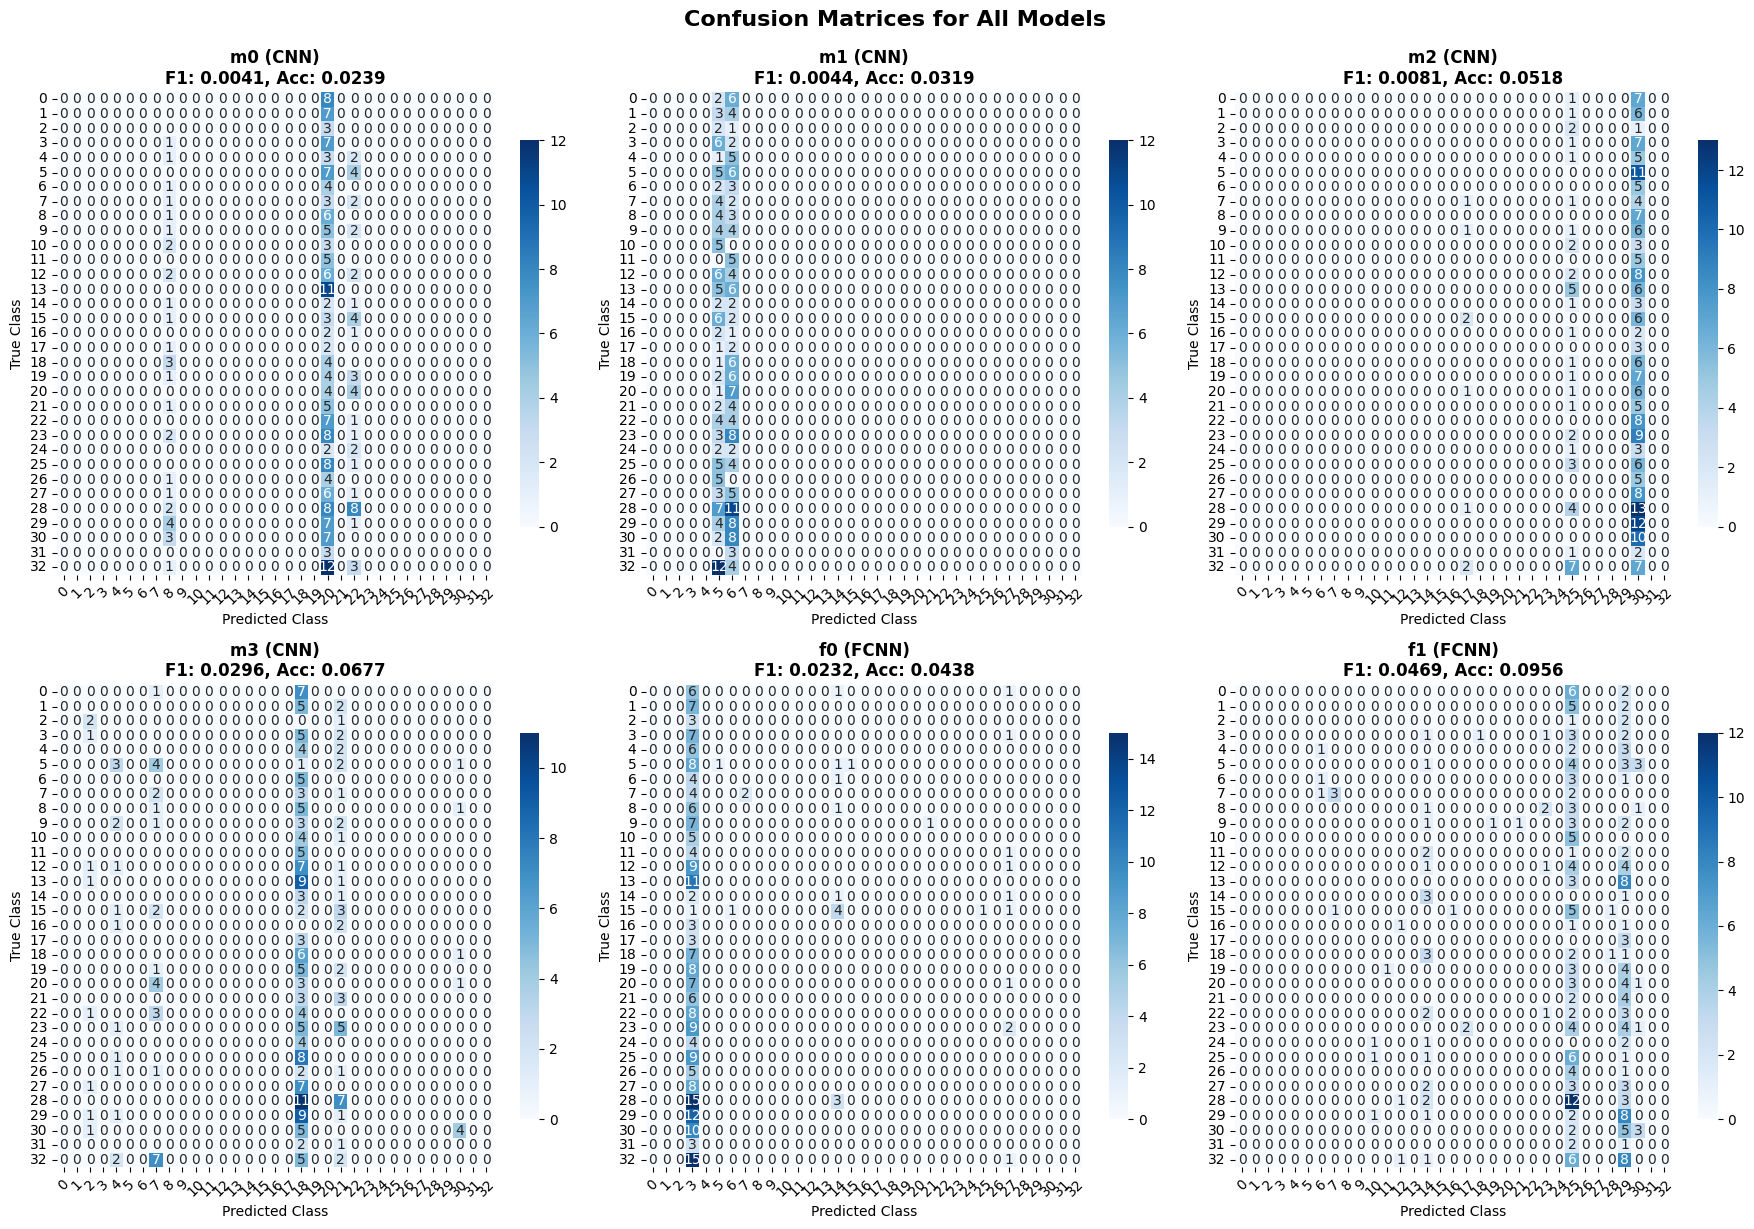


DETAILED CONFUSION MATRIX FOR BEST MODEL: f1


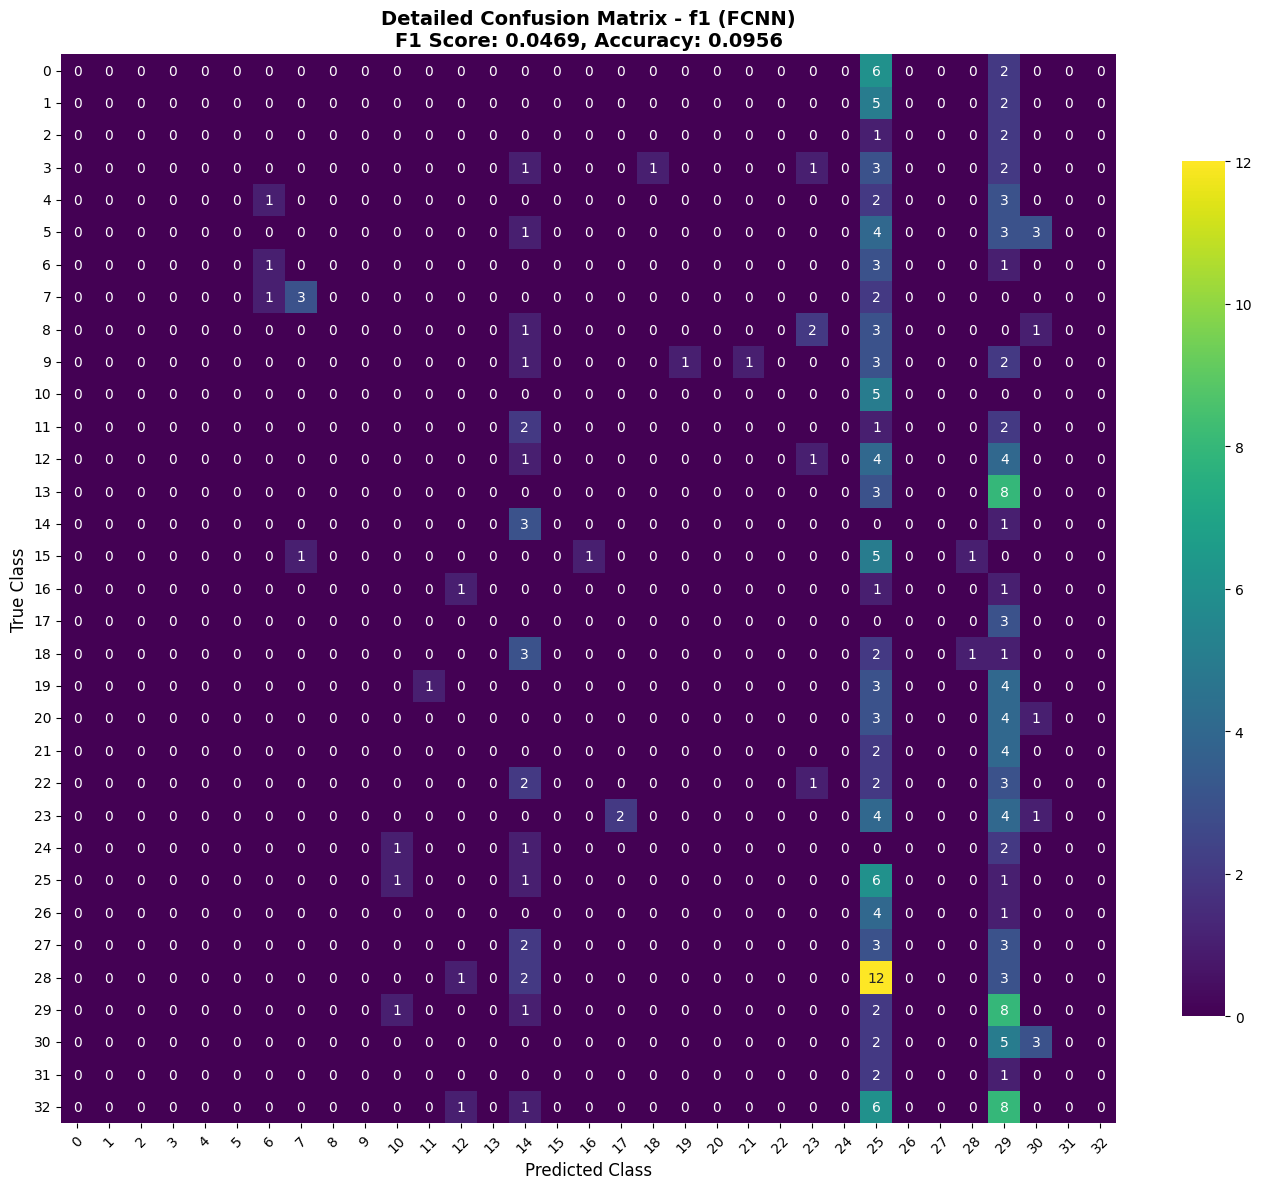


CLASSIFICATION REPORT FOR BEST MODEL: f1
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00        11
           6       0.33      0.20      0.25         5
           7       0.75      0.50      0.60         6
           8       0.00      0.00      0.00         7
           9       0.00      0.00      0.00         8
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00        10
          13       0.00      0.00      0.00        11
          14       0.13      0.75      0.22         4
          15       0.00      0.00      0.00         8
          16       0.00      0.00      

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

# Create confusion matrices for each model
import matplotlib.pyplot as plt

# Set up the subplot layout
n_models = len(all_results)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Get class labels for better visualization (you can modify this based on your class mapping)
class_labels = list(range(NUM_CLASSES))

for idx, (model_name, results) in enumerate(all_results.items()):
    # Get predictions and true labels for this model
    y_true = results['true_labels']
    y_pred = results['predictions']
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)
    
    # Plot confusion matrix
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                xticklabels=class_labels, yticklabels=class_labels,
                cbar_kws={'shrink': 0.8})
    
    # Customize the plot
    model_type = 'CNN' if model_name.startswith('m') else 'FCNN'
    ax.set_title(f'{model_name} ({model_type})\nF1: {results["f1_score"]:.4f}, Acc: {results["accuracy"]:.4f}', 
                fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted Class', fontsize=10)
    ax.set_ylabel('True Class', fontsize=10)
    
    # Rotate tick labels for better readability
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

# Remove empty subplot if any
if n_models < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.suptitle('Confusion Matrices for All Models', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Create a detailed confusion matrix for the best model
print(f"\n{'='*60}")
print(f"DETAILED CONFUSION MATRIX FOR BEST MODEL: {best_model}")
print(f"{'='*60}")

best_results = all_results[best_model]
y_true_best = best_results['true_labels']
y_pred_best = best_results['predictions']

# Create confusion matrix for best model
cm_best = confusion_matrix(y_true_best, y_pred_best, labels=class_labels)

# Plot detailed confusion matrix for best model
plt.figure(figsize=(14, 12))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='viridis', 
            xticklabels=class_labels, yticklabels=class_labels,
            cbar_kws={'shrink': 0.8})

plt.title(f'Detailed Confusion Matrix - {best_model} ({model_types[best_model_idx]})\n'
          f'F1 Score: {best_results["f1_score"]:.4f}, Accuracy: {best_results["accuracy"]:.4f}', 
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('True Class', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print classification report for best model
print(f"\nCLASSIFICATION REPORT FOR BEST MODEL: {best_model}")
print("="*60)
print(classification_report(y_true_best, y_pred_best, labels=class_labels, zero_division=0))

In [21]:
# Final Summary
print("🎯 MODEL TESTING SUMMARY")
print("="*60)

if all_results:
    print(f"Total models tested: {len(all_results)}")
    print(f"CNN models: {len(cnn_results)}")
    print(f"FCNN models: {len(fcnn_results)}")
    
    # Best performers
    best_model = max(all_results.keys(), key=lambda k: all_results[k]['f1_score'])
    worst_model = min(all_results.keys(), key=lambda k: all_results[k]['f1_score'])
    
    print(f"\n🏆 Champion: {best_model} (F1: {all_results[best_model]['f1_score']:.4f})")
    print(f"🎯 Runner-up: {worst_model} (F1: {all_results[worst_model]['f1_score']:.4f})")
    
    # Model type comparison
    cnn_scores = [results['f1_score'] for name, results in cnn_results.items()]
    fcnn_scores = [results['f1_score'] for name, results in fcnn_results.items()]
    
    if cnn_scores and fcnn_scores:
        avg_cnn = np.mean(cnn_scores)
        avg_fcnn = np.mean(fcnn_scores)
        winner = "CNN" if avg_cnn > avg_fcnn else "FCNN"
        print(f"\n📊 Architecture Comparison:")
        print(f"   CNN average F1: {avg_cnn:.4f}")
        print(f"   FCNN average F1: {avg_fcnn:.4f}")
        print(f"   Winner: {winner} models perform better on average")
    
    # Failed files summary
    total_failed = sum(len(results['failed_files']) for results in all_results.values())
    total_files = len(test_files) * len(all_results)
    success_rate = ((total_files - total_failed) / total_files) * 100
    
    print(f"\n📈 Processing Statistics:")
    print(f"   Total inference attempts: {total_files}")
    print(f"   Successful inferences: {total_files - total_failed}")
    print(f"   Failed inferences: {total_failed}")
    print(f"   Overall success rate: {success_rate:.2f}%")
    
    print(f"\n💾 Results saved to: ../models/test_results_comparison.csv")
    print("="*60)
    print("✨ Model testing completed successfully!")
else:
    print("❌ No results available - check if models were tested properly")
    print("="*60)

🎯 MODEL TESTING SUMMARY
Total models tested: 6
CNN models: 4
FCNN models: 2

🏆 Champion: f1 (F1: 0.0469)
🎯 Runner-up: m0 (F1: 0.0041)

📊 Architecture Comparison:
   CNN average F1: 0.0115
   FCNN average F1: 0.0350
   Winner: FCNN models perform better on average

📈 Processing Statistics:
   Total inference attempts: 1524
   Successful inferences: 1506
   Failed inferences: 18
   Overall success rate: 98.82%

💾 Results saved to: ../models/test_results_comparison.csv
✨ Model testing completed successfully!
